<a href="https://www.kaggle.com/code/shedai/llm-temperature-ve-positional-encoding?scriptVersionId=249163491" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Positional Encoding Tekniklkeri

7 Yaklaşım : Sinusoidal, Learned Absolute, Relative, RoPE, ALiBi, ConvPos, NoPE

Aşağıdaki Python kodu, belirttiğiniz yedi farklı konumsal kodlama (Positional Encoding) tekniğini, tek bir örnek metin üzerinden adım adım uygular. Her yöntemin felsefesini, ara adımlarını ve nihai çıktısını net bir şekilde görebilmeniz için bolca açıklama ve print ifadesi içerir.

**Kodun Yapısı ve Anlatımı**

Kod, bir cümleyi işlerken her bir PE tekniğinin ne yaptığını canlandırır. İki ana kategoriye ayrılır:

* Vektör Modifikasyonu Yapanlar (Sinusoidal, Learned, RoPE, ConvPos): Bu yöntemler, kelimelerin embedding vektörlerini, attention mekanizmasına girmeden önce değiştirir.

* Attention Skorunu Modifiye Edenler (ALiBi, Relative/T5): Bu yöntemler, embedding vektörlerine dokunmaz. Bunun yerine, attention mekanizmasının içinde, Query ve Key etkileşiminden doğan skorlara bir "yanlılık" (bias) ekler.

* Baseline (NoPE): Hiçbir şey yapmayan ve karşılaştırma için temel oluşturan durum.

Bu yapı, yöntemler arasındaki temel felsefe farkını anlamak için çok önemlidir.

Senaryo: input_sentence = "yapay zeka geleceği şekillendiriyor" cümlesini ele alacağız ve özellikle "geleceği"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time

# --- BÖLÜM 0: KURULUM VE GENEL HAZIRLIK ---

# Genel Ayarlar
D_MODEL = 32  # Anlaşılırlık için embedding boyutu
input_sentence = "yapay zeka geleceği şekillendiriyor"
tokens = input_sentence.split()
SEQ_LEN = len(tokens)
VOCAB = {"<pad>": 0, **{word: i+1 for i, word in enumerate(sorted(list(set(tokens))))}}
token_ids = torch.tensor([VOCAB[word] for word in tokens])

# Modelin temel embedding katmanı
embedding_layer = nn.Embedding(len(VOCAB) + 1, D_MODEL)
word_embeddings = embedding_layer(token_ids)

# Karşılaştırmada odaklanacağımız kelime ve pozisyonu
TARGET_WORD_INDEX = 2
TARGET_WORD = tokens[TARGET_WORD_INDEX]


def print_header(title):
    print("\n" + "="*70)
    print(f"### {title} ###")
    print("="*70)

def print_step(step_title, delay=0.5):
    print(f"\n--- {step_title} ---\n")
    time.sleep(delay)

print_header("7 Farklı Positional Encoding Tekniğinin Karşılaştırmalı Simülasyonu")
print(f"Örnek Cümle: '{input_sentence}'")
print(f"Odak Kelime: '{TARGET_WORD}' (Pozisyon: {TARGET_WORD_INDEX})")
print(f"Vektör Boyutu (d_model): {D_MODEL}")
print_step("Başlangıç: Orijinal Kelime Embedding'leri (Pozisyon Bilgisi Yok)")
print(f"'{TARGET_WORD}' kelimesinin orijinal embedding vektörünün başı:\n{word_embeddings[TARGET_WORD_INDEX, :8].detach().numpy().round(2)}...")


# ==============================================================================
# KATEGORİ 1: VEKTÖR MODİFİKASYONU YAPAN YÖNTEMLER
# ==============================================================================

# --- YÖNTEM 1: Sinusoidal PE (Mutlak, Sabit) ---
print_header("YÖNTEM 1: Sinusoidal Positional Encoding")

def get_sinusoidal_pe(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

pe_matrix = get_sinusoidal_pe(SEQ_LEN, D_MODEL)
pe_vector = pe_matrix[TARGET_WORD_INDEX]
final_vector_sinusoidal = word_embeddings[TARGET_WORD_INDEX] + pe_vector
print(f"'{TARGET_WORD}' için pozisyon vektörü (özet):\n{pe_vector[:8].numpy().round(2)}...")
print(f"SONUÇ: Pozisyon bilgisi eklenmiş yeni vektör (özet):\n{final_vector_sinusoidal.detach().numpy().round(2)}...")
print("YORUM: Vektöre sabit, matematiksel bir pozisyon imzası eklendi.")


# --- YÖNTEM 2: Learned Absolute PE (Mutlak, Öğrenilmiş) ---
print_header("YÖNTEM 2: Learned Absolute Positional Encoding")
learned_pe_layer = nn.Embedding(SEQ_LEN, D_MODEL)
learned_pe_vector = learned_pe_layer(torch.tensor(TARGET_WORD_INDEX))
final_vector_learned = word_embeddings[TARGET_WORD_INDEX] + learned_pe_vector
print(f"'{TARGET_WORD}' için öğrenilebilir pozisyon vektörü (rastgele) (özet):\n{learned_pe_vector.detach().numpy()[:8].round(2)}...")
print(f"SONUÇ: Pozisyon bilgisi eklenmiş yeni vektör (özet):\n{final_vector_learned.detach().numpy()[:8].round(2)}...")
print("YORUM: Bu pozisyon vektörü, eğitim sırasında veriye göre optimize edilir.")


# --- YÖNTEM 3: Rotary Positional Encoding (RoPE) (Göreceli, Sabit) ---
print_header("YÖNTEM 3: Rotary Positional Encoding (RoPE)")

def apply_rotary_pos_emb(x, pos, d_model):
    angle_rads = 1 / (10000 ** (torch.arange(0, d_model, 2).float() / d_model))
    angles = pos * angle_rads
    cos_val = torch.cos(angles).repeat_interleave(2)
    sin_val = torch.sin(angles).repeat_interleave(2)
    x_rotated_part = torch.cat([-x[1::2], x[0::2]], dim=-1)
    return x * cos_val + x_rotated_part * sin_val

rotated_vector_rope = apply_rotary_pos_emb(word_embeddings[TARGET_WORD_INDEX], TARGET_WORD_INDEX, D_MODEL)
print(f"SONUÇ: Pozisyon bilgisiyle 'döndürülmüş' yeni vektör (özet):\n{rotated_vector_rope.detach().numpy()[:8].round(2)}...")
print("YORUM: Vektöre bir şey eklenmedi, değerleri pozisyona göre değiştirildi (döndürüldü).")


# --- YÖNTEM 4: ConvPos (Yerel/Lokal, Öğrenilmiş) ---
print_header("YÖNTEM 4: Convolutional Positional Encoding (ConvPos)")
# Kernel size 3, yani her kelime kendisi ve sağındaki/solundaki komşusundan etkilenir
conv_layer = nn.Conv1d(in_channels=D_MODEL, out_channels=D_MODEL, kernel_size=3, padding=1)
# Conv1d (Batch, Channels, Length) formatı bekler
conv_input = word_embeddings.unsqueeze(0).permute(0, 2, 1)
conv_output = conv_layer(conv_input).permute(0, 2, 1).squeeze(0)
final_vector_conv = conv_output[TARGET_WORD_INDEX]
print(f"'{TARGET_WORD}' kelimesinin komşuları: '{tokens[TARGET_WORD_INDEX-1]}' ve '{tokens[TARGET_WORD_INDEX+1]}'")
print(f"SONUÇ: Komşularının bilgisiyle harmanlanmış yeni vektör (özet):\n{final_vector_conv.detach().numpy()[:8].round(2)}...")
print("YORUM: Vektör artık sadece kendi anlamını değil, yerel komşularının da bilgisini içeriyor.")


# ==============================================================================
# KATEGORİ 2: ATTENTION SKORUNU MODİFİYE EDEN YÖNTEMLER
# ==============================================================================
print_header("KATEGORİ 2: ATTENTION SKORUNU DEĞİŞTİREN YÖNTEMLER")
# Bu yöntemler için, (Query @ Key.T) sonrası oluşan bir skor matrisini simüle edelim.
dummy_attn_scores = torch.randn(SEQ_LEN, SEQ_LEN)
print("Bu yöntemler, aşağıdaki simüle edilmiş (rastgele) Attention Skor Matrisini değiştirir.")
print(dummy_attn_scores.numpy().round(2))

# --- YÖNTEM 5: ALiBi (Göreceli, Sabit Bias) ---
print_header("YÖNTEM 5: Attention with Linear Biases (ALiBi)")
distances = torch.arange(SEQ_LEN).view(-1, 1) - torch.arange(SEQ_LEN).view(1, -1)
# Slope (eğim) sabiti, genellikle başlık sayısına göre belirlenir. Biz bir sabit seçelim.
slope = -0.5
alibi_bias = torch.abs(distances.float()) * slope
final_scores_alibi = dummy_attn_scores + alibi_bias
print("\nALiBi tarafından hesaplanan 'mesafe cezası' (bias) matrisi:")
print(alibi_bias.numpy().round(2))
print("\nSONUÇ: ALiBi bias'ı eklenmiş yeni attention skorları:")
print(final_scores_alibi.numpy().round(2))
print("YORUM: Uzak kelimelerin skoru (sağ üst/sol alt köşeler) daha fazla düşürüldü.")


# --- YÖNTEM 6: Relative PE (T5 Stili) (Göreceli, Öğrenilmiş Bias) ---
print_header("YÖNTEM 6: Relative PE (T5 Stili)")
num_buckets = 8
relative_bias_table = nn.Embedding(num_buckets, 1)
# Mesafeleri kovalara ayıran basit bir fonksiyon
relative_positions = torch.arange(SEQ_LEN).view(-1, 1) - torch.arange(SEQ_LEN).view(1, -1)
# Basit bir kovalama:
bucket_indices = torch.clamp(relative_positions + num_buckets//2, 0, num_buckets-1)
t5_bias = relative_bias_table(bucket_indices).squeeze(-1)
final_scores_t5 = dummy_attn_scores + t5_bias
print("\nHer mesafe için atanan 'kova' indeksleri:")
print(bucket_indices.numpy())
print("\nÖğrenilebilir bias tablosundan gelen yanlılık değerleri (rastgele):")
print(t5_bias.detach().numpy().round(2))
print("\nSONUÇ: T5 stili bias eklenmiş yeni attention skorları:")
print(final_scores_t5.detach().numpy().round(2))
print("YORUM: ALiBi'den farklı olarak, bu bias değerleri eğitim sırasında öğrenilir.")


# ==============================================================================
# KATEGORİ 3: BASELINE
# ==============================================================================

# --- YÖNTEM 7: NoPE (No Positional Encoding) ---
print_header("YÖNTEM 7: No Positional Encoding (NoPE)")
print("Bu yaklaşımda, pozisyon bilgisi eklemek için hiçbir işlem yapılmaz.")
print(f"SONUÇ: '{TARGET_WORD}' kelimesinin vektörü değişmeden kalır (özet):\n{word_embeddings[TARGET_WORD_INDEX, :8].detach().numpy().round(2)}...")
print("YORUM: Bu, Transformer'ın 'doğal' halidir ve kelimelerin sırasını ayırt edemez.")


# ==============================================================================
# FİNAL ÖZET
# ==============================================================================
print_header("FİNAL ÖZET VE KARŞILAŞTIRMA")
print("""
Bu 7 yöntem, pozisyon bilgisini modellemeye yönelik farklı felsefeleri temsil eder:

1.  MUTLAK VE SABİT (Sinusoidal): "Konum evrensel bir kuraldır, matematiksel olarak öğretelim."
    - Avantaj: Verimli, mükemmel genelleme. Dezavantaj: Esnek değil.

2.  MUTLAK VE ÖĞRENİLMİŞ (Learned): "Konumun en iyi temsilini veriden öğrenelim."
    - Avantaj: Esnek. Dezavantaj: Genellemesi zayıf, maliyetli.

3.  GÖRECELİ VE DÖNER (RoPE): "Konumu, vektörlerin doğal etkileşimine içsel bir özellik olarak kodlayalım."
    - Avantaj: Zarif, parametresiz, mükemmel genelleme. Modern modellerin tercihi.

4.  YEREL VE KONVOLÜSYONEL (ConvPos): "Konumu, kelimenin yakın komşularıyla olan ilişkisi olarak öğretelim."
    - Avantaj: Dilin yerel yapısını iyi yakalar.

5.  GÖRECELİ VE SABİT BİAS (ALiBi): "Uzak kelimeler daha az önemlidir, bu kuralı skorlara basitçe ekleyelim."
    - Avantaj: Çok basit, etkili, mükemmel genelleme.

6.  GÖRECELİ VE ÖĞRENİLMİŞ BİAS (T5 Stili): "Uzaklığın etkisini de veriden öğrenelim."
    - Avantaj: Esnek bir bias sağlar. Dezavantaj: Ek parametreler ve karmaşıklık.
    
7.  POZİSYONSUZ (NoPE): "Pozisyonu tamamen yok sayalım." (Bazı özel mimarilerde kullanılır)
    - Bu bizim temel karşılaştırma noktamızdır.
""")


### 7 Farklı Positional Encoding Tekniğinin Karşılaştırmalı Simülasyonu ###
Örnek Cümle: 'yapay zeka geleceği şekillendiriyor'
Odak Kelime: 'geleceği' (Pozisyon: 2)
Vektör Boyutu (d_model): 32

--- Başlangıç: Orijinal Kelime Embedding'leri (Pozisyon Bilgisi Yok) ---

'geleceği' kelimesinin orijinal embedding vektörünün başı:
[ 1.45  0.32 -0.38  0.34 -0.37  0.46  0.87  0.2 ]...

### YÖNTEM 1: Sinusoidal Positional Encoding ###
'geleceği' için pozisyon vektörü (özet):
[ 0.91 -0.42  0.9   0.43  0.59  0.81  0.35  0.94]...
SONUÇ: Pozisyon bilgisi eklenmiş yeni vektör (özet):
[ 2.36 -0.09  0.52  0.78  0.22  1.27  1.22  1.14  0.67  0.43 -0.1   0.91
  1.42  0.75 -0.76  1.01  1.51  0.72  1.12  0.67 -0.96  0.6  -1.16  3.2
 -0.09  2.01  0.79  2.54 -0.43  0.01 -1.22  0.26]...
YORUM: Vektöre sabit, matematiksel bir pozisyon imzası eklendi.

### YÖNTEM 2: Learned Absolute Positional Encoding ###
'geleceği' için öğrenilebilir pozisyon vektörü (rastgele) (özet):
[ 0.98 -1.12  0.48 -1.31  0.57 -0.45 -

# Embedding, Attention ve Decoder ile Cümle Üretimi

Bu, öğrendiğimiz tüm kavramları (Embedding, Attention, Decoder) bir araya getirerek, modern bir sohbet robotunun temel "düşünme" sürecini gösteren, uçtan uca ve öğretici bir kod örneği olacak.

Bu kod, bir soruya cevap üretirken her bir bileşenin ne işe yaradığını ve bir sonraki aşamaya nasıl bir "kazanım" sağladığını adım adım ara çıktılarla gösterecek şekilde tasarlanmıştır.

**Senaryo ve Anlatım Akışı**

Bir soru-cevap chatbot'u yapacağız. Hikayemiz üç aşamadan oluşacak:

* Aşama 1: Embedding - Anlam Dünyasına Giriş: Bir cümlenin kelimelerini, makinenin anlayabileceği sayılara (vektörlere) nasıl dönüştürdüğümüzü göreceğiz.

* Aşama 2: Attention - Akıllıca Odaklanma: Cevap üretirken, Decoder'ın orijinal sorudaki hangi kelimelere "daha fazla dikkat etmesi" gerektiğini nasıl anladığını görselleştireceğiz.

* Aşama 3: Decoder - Cümle Kurma Sanatı: Bu odaklanmış bilgiyi alan Decoder'ın, nasıl adım adım tutarlı ve bağlama uygun bir cevap cümlesi inşa ettiğini izleyeceğiz.

* Mimari: Bu örnek için, Attention mekanizmasının rolünü en net şekilde gösterebilen Attention'lı Encoder-Decoder (RNN/GRU tabanlı) yapısını kullanacağız.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")

# --- Adım 0: Kurulum ve Veri Hazırlığı ---
device = torch.device("cpu")
SOS_token = 0; EOS_token = 1; UNK_token = 2

class Lang:
    def __init__(self):
        self.word2index = {}; self.index2word = {0: "SOS", 1: "EOS", 2: "<UNK>"}; self.n_words = 3
    def addSentence(self, sentence):
        for word in sentence.split(' '): self.addWord(word)
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words; self.index2word[self.n_words] = word; self.n_words += 1

def sentence_to_tensor(lang, sentence):
    indexes = [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]
    indexes.append(EOS_token)
    return torch.LongTensor(indexes).view(-1, 1).to(device)

qa_pairs = [
    ("nasılsın", "iyiyim teşekkür ederim sorduğun için"),
    ("senin adın ne", "benim adım yapay zeka sohbet robotu"),
    ("ne yapabilirsin", "sana basit konularda cevaplar verebilirim"),
    ("hava nasıl bugün", "üzgünüm ama hava durumunu henüz bilemiyorum"),
    ("teşekkür ederim", "rica ederim başka bir sorun var mıydı"),
    ("kaç yaşındasın", "ben bir yazılımım benim yaşım olmaz")
]
input_lang = Lang(); output_lang = Lang()
for q, a in qa_pairs: input_lang.addSentence(q); output_lang.addSentence(a)

# --- Modeller (Hata Düzeltildi ve Attention Eklendi) ---
hidden_size = 128
max_length = 20 # Maksimum cümle uzunluğu

# Encoder, cümlenin sıralı anlamını tek bir vektöre kodlar.
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        # HATA DÜZELTİLDİ: self.hidden_size burada tanımlanmalı.
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self): return torch.zeros(1, 1, self.hidden_size, device=device)

# AttnDecoderRNN, her adımda Encoder'ın çıktılarına "dikkat ederek" yeni kelime üretir.
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = nn.Linear(hidden_size * 2, max_length)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(self.attention(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

# --- Eğitim Fonksiyonu ---
def train(inp_t, tar_t, enc, dec, enc_opt, dec_opt, crit):
    enc_h = enc.initHidden(); enc_opt.zero_grad(); dec_opt.zero_grad(); loss=0
    enc_outs = torch.zeros(max_length, enc.hidden_size, device=device)
    for ei in range(len(inp_t)):
        enc_out, enc_h = enc(inp_t[ei], enc_h)
        enc_outs[ei] = enc_out[0, 0]
        
    dec_i=torch.tensor([[SOS_token]], device=device); dec_h=enc_h
    for di in range(len(tar_t)):
        dec_o, dec_h, _ = dec(dec_i, dec_h, enc_outs)
        loss += crit(dec_o, tar_t[di]); dec_i = tar_t[di]
        if dec_i.item() == EOS_token: break
    loss.backward(); enc_opt.step(); dec_opt.step()
    return loss.item() / len(tar_t)

# --- Eğitim ---
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
encoder_optimizer = optim.SGD(encoder.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=0.01)
criterion = nn.NLLLoss()

print("Chatbot modeli eğitiliyor...")
for i in range(10000): # Eğitim iterasyonları
    pair = random.choice(qa_pairs)
    input_tensor = sentence_to_tensor(input_lang, pair[0])
    target_tensor = sentence_to_tensor(output_lang, pair[1])
    train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
print("Eğitim tamamlandı.")


# --- UÇTAN UCA GÖSTERİM FONKSİYONU ---
def respond_and_explain(sentence):
    print(f"\n========================================================")
    print(f">>> KULLANICI SORUSU: '{sentence}'")
    print("========================================================")
    with torch.no_grad():
        # --- AŞAMA 1: EMBEDDING ---
        print("\n--- AŞAMA 1: EMBEDDING (Anlamı Sayısallaştırma) ---")
        input_tensor = sentence_to_tensor(input_lang, sentence)
        embedded_vectors = encoder.embedding(input_tensor).squeeze(1)
        print(f"'{sentence}' cümlesi, her kelime için {hidden_size} boyutlu vektörler içeren bir tensöre dönüştürüldü.")
        print(">>> KAZANIM: Metin, artık makinenin işleyebileceği bir formata sahip.\n")
        
        # Encoder
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        for ei in range(len(input_tensor)):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
            
        # Decoder
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        print("\n--- AŞAMA 2 & 3: ATTENTION (Odaklanma) ve DECODER (Üretme) ---")
        for di in range(max_length):
            # Her adımda Attention ve Decoder birlikte çalışır
            decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            # --- ARA ÇIKTILAR ---
            decoder_attentions[di] = attn_weights.data
            topv, topi = decoder_output.data.topk(1)
            word_index = topi.item()
            
            print(f" Adım {di+1}:")
            # AŞAMA 2'NİN KAZANIMI
            print("   - ATTENTION: Girdi cümlesindeki kelimelere dikkat odakları:")
            attention_slice = attn_weights.squeeze(0).squeeze(0).numpy()
            for i, word in enumerate(sentence.split(' ')):
                print(f"     '{word}': {attention_slice[i]:.2f}", end=" | ")
            print("\n   >>> KAZANIM: Decoder, şu an üreteceği kelime için sorunun en ilgili kısmına odaklandı.")
            
            # AŞAMA 3'ÜN KAZANIMI
            word = output_lang.index2word[word_index]
            print(f"   - DECODER: Odaklanmış bilgiyi kullanarak '{word}' kelimesini üretti.")
            print(f"   >>> KAZANIM: Cevap, kelime kelime, bağlama uygun şekilde sıfırdan inşa ediliyor.\n")
            
            if word_index == EOS_token: break
            decoded_words.append(word)
            decoder_input = topi.squeeze().detach()

        return ' '.join(decoded_words), decoder_attentions[:di + 1, :len(sentence.split(' '))]

# --- İnteraktif Sohbet ---
print("\n--- SOHBET BAŞLATILDI (Çıkmak için 'exit' yazın) ---")
user_input = "merhaba"
response, attentions = respond_and_explain(user_input)
print("\n--------------------------------------------------------")
print(f"Bot Cevabı: {response}")
print("--------------------------------------------------------")
'''
while True:
    try:
        user_input = input("Siz: ")
        if user_input.lower() == 'exit':
            break
        response, attentions = respond_and_explain(user_input)
        print("\n--------------------------------------------------------")
        print(f"Bot Cevabı: {response}")
        print("--------------------------------------------------------")
    except KeyError:
        print("Bot: Üzgünüm, bu kelimelerden bazılarını bilmiyorum. Başka bir şey sorabilir misin?")
    except Exception as e:
        print(f"Bir hata oluştu: {e}")
'''

Chatbot modeli eğitiliyor...
Eğitim tamamlandı.

--- SOHBET BAŞLATILDI (Çıkmak için 'exit' yazın) ---

>>> KULLANICI SORUSU: 'merhaba'

--- AŞAMA 1: EMBEDDING (Anlamı Sayısallaştırma) ---
'merhaba' cümlesi, her kelime için 128 boyutlu vektörler içeren bir tensöre dönüştürüldü.
>>> KAZANIM: Metin, artık makinenin işleyebileceği bir formata sahip.


--- AŞAMA 2 & 3: ATTENTION (Odaklanma) ve DECODER (Üretme) ---
 Adım 1:
   - ATTENTION: Girdi cümlesindeki kelimelere dikkat odakları:
     'merhaba': 0.07 | 
   >>> KAZANIM: Decoder, şu an üreteceği kelime için sorunun en ilgili kısmına odaklandı.
   - DECODER: Odaklanmış bilgiyi kullanarak 'iyiyim' kelimesini üretti.
   >>> KAZANIM: Cevap, kelime kelime, bağlama uygun şekilde sıfırdan inşa ediliyor.

 Adım 2:
   - ATTENTION: Girdi cümlesindeki kelimelere dikkat odakları:
     'merhaba': 0.02 | 
   >>> KAZANIM: Decoder, şu an üreteceği kelime için sorunun en ilgili kısmına odaklandı.
   - DECODER: Odaklanmış bilgiyi kullanarak 'teşekkür' kel

'\nwhile True:\n    try:\n        user_input = input("Siz: ")\n        if user_input.lower() == \'exit\':\n            break\n        response, attentions = respond_and_explain(user_input)\n        print("\n--------------------------------------------------------")\n        print(f"Bot Cevabı: {response}")\n        print("--------------------------------------------------------")\n    except KeyError:\n        print("Bot: Üzgünüm, bu kelimelerden bazılarını bilmiyorum. Başka bir şey sorabilir misin?")\n    except Exception as e:\n        print(f"Bir hata oluştu: {e}")\n'

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import torch.nn.functional as F
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# --- Genel Kurulum ---
device = torch.device("cpu")
SOS_token = 0; EOS_token = 1; UNK_token = 2

# Daha uzun ve çeşitli cümleler içeren veri seti
qa_pairs = [
    ("nasılsın", "iyiyim teşekkür ederim sorduğun için"),
    ("senin adın ne", "benim adım yapay zeka sohbet robotu"),
    ("ne yapabilirsin", "sana basit konularda doğru cevaplar verebilirim"),
    ("bugün hava nasıl", "üzgünüm ama hava durumunu henüz bilemiyorum"),
    ("en sevdiğin renk ne", "bir yazılım olarak renkleri göremem"),
    ("en sevdiğin renk nedir","doğanın bütün renkleri güzel ama ben göremem"),
    ("en sevdiğin renkler neler","bütün renkleri görmek isterdim ama bir yazılım olarak göremem"),
    ("en sevdiğin renk ne","yazılım olarak bir renk görmem mümkün değil ama mavinin güzel bir renk olduğunu duyuyorum"),
    ("sevdiğin en güzel renk ne","yeşil ve kırmızı renkleri görmek isterdim ama göremem mavinin güzel olduğunu duyuyorum"),
    ("bana bir şaka anlat", "neden yapay zeka hiç kaybolmaz çünkü her zaman evdeki sunucusuna döner"),
    ("teşekkürler", "rica ederim başka bir sorun var mıydı")
]

class Lang:
    def __init__(self): self.word2index = {}; self.index2word = {0:"SOS", 1:"EOS", 2:"<UNK>"}; self.n_words = 3
    def addSentence(self, sentence):
        for word in sentence.split(' '): self.addWord(word)
    def addWord(self, word):
        if word not in self.word2index: self.word2index[word]=self.n_words; self.index2word[self.n_words]=word; self.n_words+=1

input_lang = Lang(); output_lang = Lang()
for q, a in qa_pairs: input_lang.addSentence(q); output_lang.addSentence(a)

def sentence_to_tensor(lang, sentence):
    indexes = [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]
    indexes.append(EOS_token)
    return torch.LongTensor(indexes).view(-1, 1).to(device)

# --- AŞAMA 1: Sadece Embedding Kullanan "Kelime Avcısı" Bot ---
print("="*80)
print("--- Bot 1: 'Kelime Avcısı' (Sadece Embedding Yeteneği) ---")

def simple_keyword_bot(user_input, qa_database):
    print(f"\n[Bot 1] Kullanıcı Sorusu: '{user_input}'")
    input_words = set(user_input.split(' '))
    best_match_score = 0
    best_answer = "Üzgünüm, bu konuda bir bilgim yok."

    for question, answer in qa_database:
        question_words = set(question.split(' '))
        match_score = len(input_words.intersection(question_words))
        if match_score > best_match_score:
            best_match_score = match_score
            best_answer = answer
            
    print(f"[Bot 1] Cevap (Hazır Cevaplardan Seçim): '{best_answer}'")
    print("\n>>> KAZANIM: Embedding'in temel fikri olan kelime eşleştirme sayesinde basit bir cevap bulabildik.")
    print(">>> EKSİKLİK: Cümle yapısı, gramer veya bağlam tamamen yok sayıldı. Yeni bir cümle kuramıyor, sadece ezberindekini tekrar ediyor.")

# --- AŞAMA 2 & 3 için Ortak Modeller ---
hidden_size = 128
max_length = 25

class Encoder(nn.Module):
    def __init__(self, i_s, h_s): super(Encoder, self).__init__(); self.h_s=h_s; self.emb=nn.Embedding(i_s,h_s); self.gru=nn.GRU(h_s,h_s)
    def forward(self, i, h): e=self.emb(i).view(1,1,-1); o,h=self.gru(e,h); return o,h
    def initHidden(self): return torch.zeros(1, 1, self.h_s, device=device)

class Decoder(nn.Module): # Attention'SIZ Decoder
    def __init__(self, h_s, o_s): super(Decoder, self).__init__(); self.emb=nn.Embedding(o_s,h_s); self.gru=nn.GRU(h_s,h_s); self.out=nn.Linear(h_s,o_s); self.softmax=nn.LogSoftmax(dim=1)
    def forward(self, i, h): o=self.emb(i).view(1,1,-1); o=F.relu(o); o,h=self.gru(o,h); o=self.softmax(self.out(o[0])); return o,h
    
class AttnDecoder(nn.Module): # Attention'LI Decoder
    def __init__(self, h_s, o_s, dropout_p=0.1):
        super(AttnDecoder, self).__init__(); self.emb=nn.Embedding(o_s,h_s); self.attn=nn.Linear(h_s*2,max_length); self.attn_combine=nn.Linear(h_s*2,h_s); self.dropout=nn.Dropout(dropout_p); self.gru=nn.GRU(h_s,h_s); self.out=nn.Linear(h_s,o_s)
    def forward(self, i, h, enc_outs):
        e=self.emb(i).view(1,1,-1); e=self.dropout(e)
        aw=F.softmax(self.attn(torch.cat((e[0],h[0]),1)),dim=1); aa=torch.bmm(aw.unsqueeze(0),enc_outs.unsqueeze(0))
        o=torch.cat((e[0],aa[0]),1); o=self.attn_combine(o).unsqueeze(0); o=F.relu(o)
        o,h=self.gru(o,h); o=F.log_softmax(self.out(o[0]),dim=1); return o,h,aw

# Eğitim fonksiyonu
def train_seq2seq(inp_t, tar_t, enc, dec, enc_opt, dec_opt, crit, use_attention=False):
    enc_h=enc.initHidden(); enc_opt.zero_grad(); dec_opt.zero_grad(); loss=0
    enc_outs=torch.zeros(max_length,enc.h_s,device=device)
    for ei in range(len(inp_t)): enc_o,enc_h = enc(inp_t[ei],enc_h); enc_outs[ei]=enc_o[0,0]
    dec_i=torch.tensor([[SOS_token]],device=device); dec_h=enc_h
    for di in range(len(tar_t)):
        if use_attention: dec_o, dec_h, _ = dec(dec_i, dec_h, enc_outs)
        else: dec_o, dec_h = dec(dec_i, dec_h)
        loss+=crit(dec_o,tar_t[di]); dec_i=tar_t[di]
        if dec_i.item() == EOS_token: break
    loss.backward(); enc_opt.step(); dec_opt.step()

# Değerlendirme fonksiyonu
def evaluate(sentence, enc, dec, use_attention=False, temperature=0.5):
    with torch.no_grad():
        inp_t=sentence_to_tensor(input_lang,sentence); enc_h=enc.initHidden()
        enc_outs=torch.zeros(max_length,enc.h_s,device=device)
        for ei in range(len(inp_t)): enc_o,enc_h=enc(inp_t[ei],enc_h); enc_outs[ei]=enc_o[0,0]
        dec_i=torch.tensor([[SOS_token]],device=device); dec_h=enc_h
        decoded_words=[]
        for di in range(max_length):
            if use_attention: dec_o,dec_h,_ = dec(dec_i,dec_h,enc_outs)
            else: dec_o,dec_h = dec(dec_i,dec_h)
            
            # YARATICILIK İÇİN TEMPERATURE SAMPLING
            decoder_output_dist = dec_o.div(temperature).exp()
            topi = torch.multinomial(decoder_output_dist, 1)[0]
            
            if topi.item() == EOS_token: break
            else: decoded_words.append(output_lang.index2word[topi.item()])
            dec_i = topi.squeeze().detach()
        return ' '.join(decoded_words)

# --- Bot 2 ve 3 için Eğitim ---
print("\n" + "="*80)
print("--- Bot 2 ve Bot 3 için Modeller Eğitiliyor ---")
# Bot 2 Modelleri (Attention'sız)
encoder2 = Encoder(input_lang.n_words, hidden_size).to(device)
decoder2 = Decoder(hidden_size, output_lang.n_words).to(device)
enc2_opt = optim.SGD(encoder2.parameters(), lr=0.01); dec2_opt = optim.SGD(decoder2.parameters(), lr=0.01)

# Bot 3 Modelleri (Attention'lı)
encoder3 = Encoder(input_lang.n_words, hidden_size).to(device)
decoder3 = AttnDecoder(hidden_size, output_lang.n_words).to(device)
enc3_opt = optim.SGD(encoder3.parameters(), lr=0.01); dec3_opt = optim.SGD(decoder3.parameters(), lr=0.01)

criterion = nn.NLLLoss()
for i in range(10000):
    pair = random.choice(qa_pairs)
    inp_t = sentence_to_tensor(input_lang, pair[0]); tar_t = sentence_to_tensor(output_lang, pair[1])
    train_seq2seq(inp_t,tar_t,encoder2,decoder2,enc2_opt,dec2_opt,criterion,use_attention=False)
    train_seq2seq(inp_t,tar_t,encoder3,decoder3,enc3_opt,dec3_opt,criterion,use_attention=True)
print("Eğitimler tamamlandı.")

# --- KARŞILAŞTIRMALI TEST ---
print("\n" + "="*80)
print("--- MODELLERİN KARŞILAŞTIRILMASI ---")

# Uzun ve detaylı bir soru seçelim
test_sentence = "en sevdiğin renk ne olabilir"

# --- Bot 1'in Cevabı ---
simple_keyword_bot(test_sentence, qa_pairs)

# --- Bot 2'nin Cevabı ---
print(f"\n[Bot 2] Kullanıcı Sorusu: '{test_sentence}'")
response2 = evaluate(test_sentence, encoder2, decoder2, use_attention=False)
print(f"[Bot 2] Cevap (Attention'sız Encoder-Decoder): '{response2}'")
print("\n>>> KAZANIM: Artık ezberlemiyor, kelime kelime yeni bir cümle üretiyoruz.")
print(">>> EKSİKLİK: Cümle uzun olduğunda, Encoder'ın ürettiği tek bir 'özet vektörü' yetersiz kalıyor. Model, cümlenin başındaki 'renk' gibi önemli bir detayı unutabiliyor ve genel bir cevap veriyor.")

# --- Bot 3'ün Cevabı ---
print(f"\n[Bot 3] Kullanıcı Sorusu: '{test_sentence}'")
print("Not: Yaratıcılık için Temperature Sampling kullanıldığından, her seferinde biraz farklı cevaplar alabilirsiniz.")
response3 = evaluate(test_sentence, encoder3, decoder3, use_attention=True, temperature=0.7)
print(f"[Bot 3] Cevap (Attention'lı Encoder-Decoder): '{response3}'")
print("\n>>> KAZANIM: Attention sayesinde Decoder, cevabı üretirken sorunun en kilit kısmına ('renk' kelimesine) odaklanabildi ve bu sayede çok daha isabetli bir cevap üretti.")
print(">>> KAZANIM: Sıcaklık (temperature) parametresi, modele deterministik olmak yerine olasılıksal ve yaratıcı cevaplar üretme yeteneği kazandırdı.")

print("\n" + "="*80)
print("SONUÇ: Embedding ile başladık, Encoder-Decoder ile cümle kurmayı öğrendik ve son olarak Attention ile bu yeteneği akıllı ve odaklı hale getirdik.")

--- Bot 1: 'Kelime Avcısı' (Sadece Embedding Yeteneği) ---

--- Bot 2 ve Bot 3 için Modeller Eğitiliyor ---
Eğitimler tamamlandı.

--- MODELLERİN KARŞILAŞTIRILMASI ---

[Bot 1] Kullanıcı Sorusu: 'en sevdiğin renk ne olabilir'
[Bot 1] Cevap (Hazır Cevaplardan Seçim): 'bir yazılım olarak renkleri göremem'

>>> KAZANIM: Embedding'in temel fikri olan kelime eşleştirme sayesinde basit bir cevap bulabildik.
>>> EKSİKLİK: Cümle yapısı, gramer veya bağlam tamamen yok sayıldı. Yeni bir cümle kuramıyor, sadece ezberindekini tekrar ediyor.

[Bot 2] Kullanıcı Sorusu: 'en sevdiğin renk ne olabilir'
[Bot 2] Cevap (Attention'sız Encoder-Decoder): 'bir yazılım olarak renkleri göremem'

>>> KAZANIM: Artık ezberlemiyor, kelime kelime yeni bir cümle üretiyoruz.
>>> EKSİKLİK: Cümle uzun olduğunda, Encoder'ın ürettiği tek bir 'özet vektörü' yetersiz kalıyor. Model, cümlenin başındaki 'renk' gibi önemli bir detayı unutabiliyor ve genel bir cevap veriyor.

[Bot 3] Kullanıcı Sorusu: 'en sevdiğin renk ne olabi

# Temperature Yaklaşımlar (Top-k, Top-p)

In [5]:
import torch
import torch.nn.functional as F
import numpy as np

# --- GİRİŞ VE KURULUM ---
# Bu script, bir dil modelinin metin üretme anındaki tek bir adımını simüle eder.
# Amaç, Temperature, Greedy Search, Top-k ve Top-p (Nucleus) gibi kavramların
# modelin nihai çıktısını nasıl şekillendirdiğini adım adım görmektir.
#
# Senaryo: Bir dil modeli, "İstanbul Türkiye'nin en kalabalık" cümlesini işledi
# ve şimdi bir sonraki kelimeye karar verecek. Modelin olası kelimeler için
# ürettiği ham skorlardan (logit) yola çıkarak, farklı parametrelerin sonucu
# nasıl değiştirdiğini inceleyeceğiz.

print("--- Adım Adım Üretim Simülasyonu ---")
print("Senaryo: Model, 'İstanbul Türkiye'nin en kalabalık' girdisini işledi.")
print("Şimdi bir sonraki kelimeye karar verecek.\n")

# Modelin ürettiği ham skorları (logit'leri) temsil eden bir tensor oluşturalım.
# Yüksek değer, o kelimenin daha olası olduğunu gösterir.
vocab = ["şehri", "bölgesi", "güzeli", "yeri", "yemeğidir"]
logits = torch.tensor([4.5, 2.5, 2.0, 1.0, -1.0])

print("1. Adım: Modelin Ham Çıktısı (Logits)")
for word, logit in zip(vocab, logits):
    print(f"- {word:<10}: {logit.item():.2f}")
print("-" * 40)


# --- BÖLÜM 1: TEMPERATURE (ISI) KAVRAMININ ETKİSİ ---
print("\n### BÖLÜM 1: Temperature Değerinin Olasılıklara Etkisi ###\n")

def calculate_probs(logits, temperature=1.0):
    """Verilen logit ve sıcaklık değeri için olasılıkları hesaplar ve yazdırır."""
    print(f"--- Sıcaklık (Temperature) T = {temperature} ---")
    
    # Sıcaklık değeri, Softmax fonksiyonuna girmeden önce logit'leri ölçeklendirir.
    scaled_logits = logits / temperature
    print("Sıcaklıkla ölçeklenmiş logitler:")
    for word, logit in zip(vocab, scaled_logits):
        print(f"- {word:<10}: {logit.item():.2f}")
        
    # Ölçeklenmiş logit'lerden olasılıkları hesapla (Softmax)
    probabilities = F.softmax(scaled_logits, dim=0)
    
    print("\nSonuç Olasılık Dağılımı:")
    for word, prob in zip(vocab, probabilities):
        print(f"- {word:<10}: %{prob.item()*100:.2f}")
    print("-" * 40)
    return probabilities

# Farklı sıcaklık değerleri ile olasılıkları hesaplayalım
probs_normal_temp = calculate_probs(logits, temperature=1.0) # Normal, referans durum
probs_low_temp = calculate_probs(logits, temperature=0.5)   # Düşük ısı: Model daha emin ve odaklı
probs_high_temp = calculate_probs(logits, temperature=1.5)  # Yüksek ısı: Model daha rastgele ve yaratıcı


# --- BÖLÜM 2: ÖRNEKLEME (SAMPLING) STRATEJİLERİ ---
print("\n### BÖLÜM 2: Olasılık Dağılımından Kelime Seçme Stratejileri ###")
print("Bu bölüm için T=1.0 ile üretilen normal olasılık dağılımını kullanacağız.\n")

# Strateji 1: Greedy Search (Açgözlü Arama)
print("--- Strateji 1: Greedy Search ---")
print("Yöntem: Her zaman en yüksek olasılığa sahip kelimeyi seç.")
greedy_index = torch.argmax(probs_normal_temp)
greedy_word = vocab[greedy_index]
print(f"Seçilen Kelime: '{greedy_word}' (Olasılık: %{probs_normal_temp[greedy_index].item()*100:.2f})\n")

# Strateji 2: Top-k Sampling
print("--- Strateji 2: Top-k Sampling (k=3) ---")
print("Yöntem: En olası 'k' adet kelimeden oluşan bir havuz oluştur ve bu havuzdan rastgele seç.")
k = 3
top_k_probs, top_k_indices = torch.topk(probs_normal_temp, k)

print("Oluşturulan 'Top 3' havuzu:")
for i in range(k):
    word = vocab[top_k_indices[i]]
    prob = top_k_probs[i]
    print(f"- {word:<10}: %{prob.item()*100:.2f}")

# Seçimi bu daraltılmış havuzdan yap
# torch.multinomial, verilen olasılıklara göre bir örnek seçer.
top_k_sampled_index_in_pool = torch.multinomial(top_k_probs, num_samples=1)
# Havuzdaki indeksi, orijinal kelime haznesindeki indekse çevir
final_top_k_index = top_k_indices[top_k_sampled_index_in_pool]
top_k_word = vocab[final_top_k_index]

print(f"\nBu havuzdan rastgele seçilen kelime: '{top_k_word}'\n")

# Strateji 3: Top-p (Nucleus) Sampling
print("--- Strateji 3: Top-p (Nucleus) Sampling (p=0.90) ---")
print("Yöntem: Kümülatif olasılığı 'p' değerini geçen en küçük kelime setini oluştur ve oradan seç.")
p = 0.90

# Olasılıkları büyükten küçüğe sırala
sorted_probs, sorted_indices = torch.sort(probs_normal_temp, descending=True)
cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

# Kümülatif toplamı p'yi geçenleri havuzun dışında bırak
indices_to_remove = cumulative_probs > p
# Ancak ilk kelimeyi her zaman tutmak için ilk indeksi False yap
indices_to_remove[..., 1:] = indices_to_remove[..., :-1].clone()
indices_to_remove[..., 0] = 0

indices_of_words_to_keep = sorted_indices[~indices_to_remove]
final_probs_for_p_sampling = sorted_probs[~indices_to_remove]

print("Oluşturulan 'Nucleus (Çekirdek)' havuzu (Toplam olasılık >= %90):")
for i in range(len(indices_of_words_to_keep)):
    word = vocab[indices_of_words_to_keep[i]]
    prob = probs_normal_temp[indices_of_words_to_keep[i]]
    print(f"- {word:<10}: %{prob.item()*100:.2f}")

# Seçimi bu dinamik havuzdan yap
top_p_sampled_index_in_pool = torch.multinomial(final_probs_for_p_sampling, num_samples=1)
final_top_p_index = indices_of_words_to_keep[top_p_sampled_index_in_pool]
top_p_word = vocab[final_top_p_index]
print(f"\nBu havuzdan rastgele seçilen kelime: '{top_p_word}'")
print("-" * 40)

--- Adım Adım Üretim Simülasyonu ---
Senaryo: Model, 'İstanbul Türkiye'nin en kalabalık' girdisini işledi.
Şimdi bir sonraki kelimeye karar verecek.

1. Adım: Modelin Ham Çıktısı (Logits)
- şehri     : 4.50
- bölgesi   : 2.50
- güzeli    : 2.00
- yeri      : 1.00
- yemeğidir : -1.00
----------------------------------------

### BÖLÜM 1: Temperature Değerinin Olasılıklara Etkisi ###

--- Sıcaklık (Temperature) T = 1.0 ---
Sıcaklıkla ölçeklenmiş logitler:
- şehri     : 4.50
- bölgesi   : 2.50
- güzeli    : 2.00
- yeri      : 1.00
- yemeğidir : -1.00

Sonuç Olasılık Dağılımı:
- şehri     : %79.89
- bölgesi   : %10.81
- güzeli    : %6.56
- yeri      : %2.41
- yemeğidir : %0.33
----------------------------------------
--- Sıcaklık (Temperature) T = 0.5 ---
Sıcaklıkla ölçeklenmiş logitler:
- şehri     : 9.00
- bölgesi   : 5.00
- güzeli    : 4.00
- yeri      : 2.00
- yemeğidir : -2.00

Sonuç Olasılık Dağılımı:
- şehri     : %97.47
- bölgesi   : %1.79
- güzeli    : %0.66
- yeri      : %0.09
- 

# Positional Encoding

Kod, kavramları net bir şekilde ayırmak için bölümlere ayrılmıştır ve her adımda ne yapıldığını açıklayan yorum satırları içerir.

**Kodun Yapısı ve Anlatımı**

* Bölüm 1, 2 ve 3 (Sinusoidal, Learned, RoPE): Bu yöntemler, kelime vektörlerini veya Query/Key vektörlerini attention mekanizmasına girmeden önce modifiye eder. Kod, basit bir "elma" kelimesi için örnek bir embedding vektörü oluşturur ve bu üç yöntemin, kelime farklı pozisyonlardayken bu vektörü nasıl değiştirdiğini gösterir.

* Bölüm 4 (Relative Position Bias - T5 Stili): Bu yöntem diğerlerinden temel olarak farklıdır. Girdi vektörlerini değiştirmez. Bunun yerine, attention mekanizmasının içinde, Query ve Key vektörleri arasındaki attention skorları hesaplandıktan sonra, bu skorlara doğrudan bir "konum yanlılığı" (position bias) ekler. Bu nedenle bu bölümdeki kod, diğerlerinden farklı olarak bir attention skoru matrisini simüle ederek çalışır.

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Genel Ayarlar ve Hazırlık ---
print("### 4 Farklı Konumsal Kodlama (Positional Encoding) Yönteminin Karşılaştırılması ###")
D_MODEL = 64      # Modelin embedding boyutu
MAX_SEQ_LEN = 100 # Maksimum dizi uzunluğu
sns.set_theme(style="whitegrid")

# Tüm örneklerde kullanılacak, "elma" kelimesini temsil eden basit bir vektör.
# Amacımız, PE sonrası değişimi net görmektir.
example_word_embedding = torch.ones(D_MODEL)
pos_1 = 5   # "elma" kelimesinin 5. pozisyonda olduğunu varsayalım
pos_2 = 12  # "elma" kelimesinin 12. pozisyonda olduğunu varsayalım

print(f"\nModel Embedding Boyutu (d_model): {D_MODEL}")
print(f"Karşılaştırılacak Pozisyonlar: {pos_1} ve {pos_2}")
print("-" * 60)

# ==============================================================================
# BÖLÜM 1: Sinusoidal Positional Encoding (Orijinal)
# Tip: Sabit, Konum: Mutlak, Uygulama: Embedding'e eklenir
# ==============================================================================
print("\n### BÖLÜM 1: Sinusoidal Positional Encoding ###")
print("Özellikler: Sabit, Mutlak Konum, İyi Genelleme Yeteneği")

def get_sinusoidal_pe(max_len, d_model):
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

sinusoidal_pe_matrix = get_sinusoidal_pe(MAX_SEQ_LEN, D_MODEL)
pe_pos_1 = sinusoidal_pe_matrix[pos_1]
pe_pos_2 = sinusoidal_pe_matrix[pos_2]

# Adım adım çıktı
print(f"\nAdım 1.1: 'elma' kelimesinin başlangıç vektörü (özet):\n{example_word_embedding[:5]}...")
print(f"\nAdım 1.2: Pozisyon {pos_1} için Sinusoidal PE vektörü (özet):\n{pe_pos_1[:5]}...")
print(f"\nAdım 1.3: Pozisyon {pos_2} için Sinusoidal PE vektörü (özet):\n{pe_pos_2[:5]}...")

final_embedding_1 = example_word_embedding + pe_pos_1
final_embedding_2 = example_word_embedding + pe_pos_2

print(f"\nSONUÇ 1: Pozisyon {pos_1} için son vektör (özet):\n{final_embedding_1[:5]}...")
print(f"SONUÇ 2: Pozisyon {pos_2} için son vektör (özet):\n{final_embedding_2[:5]}...")
print("Görüldüğü gibi, aynı kelime vektörü farklı pozisyonlar için farklı son vektörlere dönüştü.")
print("-" * 60)


# ==============================================================================
# BÖLÜM 2: Learned Absolute Positional Encoding
# Tip: Öğrenilmiş, Konum: Mutlak, Uygulama: Embedding'e eklenir
# ==============================================================================
print("\n### BÖLÜM 2: Learned Absolute Positional Encoding ###")
print("Özellikler: Öğrenilmiş, Mutlak Konum, Zayıf Genelleme Yeteneği")

# Her pozisyon için öğrenilebilir bir vektör tutan tablo (layer)
learned_pe_layer = nn.Embedding(MAX_SEQ_LEN, D_MODEL)

# Pozisyonları tensor olarak hazırlayalım
pos_tensor_1 = torch.tensor([pos_1], dtype=torch.long)
pos_tensor_2 = torch.tensor([pos_2], dtype=torch.long)

# Adım adım çıktı
learned_pe_pos_1 = learned_pe_layer(pos_tensor_1).squeeze(0)
learned_pe_pos_2 = learned_pe_layer(pos_tensor_2).squeeze(0)

print(f"\nAdım 2.1: Pozisyon {pos_1} için (rastgele) öğrenilmiş PE vektörü (özet):\n{learned_pe_pos_1.data[:5]}...")
print(f"\nAdım 2.2: Pozisyon {pos_2} için (rastgele) öğrenilmiş PE vektörü (özet):\n{learned_pe_pos_2.data[:5]}...")

final_learned_embedding_1 = example_word_embedding + learned_pe_pos_1
final_learned_embedding_2 = example_word_embedding + learned_pe_pos_2

print(f"\nSONUÇ 1: Pozisyon {pos_1} için son vektör (özet):\n{final_learned_embedding_1.data[:5]}...")
print(f"SONUÇ 2: Pozisyon {pos_2} için son vektör (özet):\n{final_learned_embedding_2.data[:5]}...")
print("Bu PE vektörleri, eğitim sırasında veriye göre optimize edilir.")
print(f"Not: Bu yöntem, MAX_SEQ_LEN ({MAX_SEQ_LEN}) dışındaki pozisyonları bilemez.")
print("-" * 60)

# ==============================================================================
# BÖLÜM 3: Rotary Positional Encoding (RoPE)
# Tip: Sabit, Konum: Göreceli (Örtük), Uygulama: Q/K vektörleri döndürülür
# ==============================================================================
print("\n### BÖLÜM 3: Rotary Positional Encoding (RoPE) ###")
print("Özellikler: Sabit, Göreceli Konum, Mükemmel Genelleme Yeteneği")
print("Not: RoPE, vektör eklemek yerine Query ve Key vektörlerini 'döndürür'.")

def get_rope_angles(positions, d_model):
    angle_rads = 1 / (10000 ** (torch.arange(0, d_model, 2).float() / d_model))
    return positions.unsqueeze(1) * angle_rads.unsqueeze(0)

def apply_rotary_pos_emb(x, angles):
    cos_val = torch.cos(angles).repeat_interleave(2, dim=-1)
    sin_val = torch.sin(angles).repeat_interleave(2, dim=-1)
    x_rotated_part = torch.cat([-x[..., 1::2], x[..., 0::2]], dim=-1)
    return x * cos_val + x_rotated_part * sin_val

# Adım adım çıktı
dummy_query_vector = torch.randn(D_MODEL) # Örnek bir Query vektörü
print(f"\nAdım 3.1: Örnek bir Query vektörü (özet):\n{dummy_query_vector[:5]}...")

angles_pos_1 = get_rope_angles(torch.tensor([pos_1], dtype=torch.float), D_MODEL)
rotated_query_1 = apply_rotary_pos_emb(dummy_query_vector, angles_pos_1)

angles_pos_2 = get_rope_angles(torch.tensor([pos_2], dtype=torch.float), D_MODEL)
rotated_query_2 = apply_rotary_pos_emb(dummy_query_vector, angles_pos_2)

print(f"\nSONUÇ 1: Pozisyon {pos_1} için döndürülmüş Query (özet):\n{rotated_query_1.squeeze(0)[:5]}...")
print(f"SONUÇ 2: Pozisyon {pos_2} için döndürülmüş Query (özet):\n{rotated_query_2.squeeze(0)[:5]}...")
print("RoPE'un asıl gücü, iki vektör arasındaki attention skorunun göreceli mesafeye bağlı olmasıdır.")
print("-" * 60)

# ==============================================================================
# BÖLÜM 4: Relative Position Bias (T5 Stili)
# Tip: Öğrenilmiş, Konum: Göreceli (Açık), Uygulama: Attention skorlarına eklenir
# ==============================================================================
print("\n### BÖLÜM 4: Relative Position Bias (T5 Stili) ###")
print("ÖZELLİKLE DİKKAT: Bu yöntem diğerlerinden farklı çalışır.")
print("Vektörleri DEĞİŞTİRMEZ, bunun yerine Attention skor matrisine öğrenilmiş bir 'yanlılık' (bias) ekler.")

# T5'in kullandığı standart parametreler
num_buckets = 32
max_distance = 128
# Bu bias değerleri her bir attention başlığı için ayrı ayrı öğrenilir, biz 1 başlık varsayalım.
relative_attention_bias_table = nn.Embedding(num_buckets, 1)

def compute_t5_relative_bias(seq_len):
    # Adım 4.1: Query ve Key pozisyonları arasındaki göreceli mesafeyi hesapla
    # Sonuç: `context_position[i, j] = i - j`
    context_position = torch.arange(seq_len, dtype=torch.long)[:, None]
    memory_position = torch.arange(seq_len, dtype=torch.long)[None, :]
    relative_position = memory_position - context_position

    # Adım 4.2: Bu mesafeleri "bucket" (kova) denen gruplara ayır.
    # T5'in orjinalindeki karmaşık logaritmik kovalama yerine, anlaşılır bir versiyon kullanalım.
    rp_bucket = torch.zeros_like(relative_position)
    
    # Pozitif ve negatif mesafeler için farklı kovalama
    num_buckets_half = num_buckets // 2
    rp_bucket += (relative_position > 0).long() * num_buckets_half
    
    # Mutlak mesafeyi al ve sınırla
    relative_position_abs = torch.abs(relative_position)
    max_exact = num_buckets_half // 2
    
    # Yakın mesafeleri doğrudan kovaya ata
    is_small = relative_position_abs < max_exact
    rp_bucket[is_small] += relative_position_abs[is_small]
    
    # Uzak mesafeleri logaritmik olarak grupla
    is_large = ~is_small
    val_large = max_exact + (torch.log(relative_position_abs[is_large].float() / max_exact) / np.log(max_distance / max_exact) * (num_buckets_half - max_exact)).long()
    rp_bucket[is_large] += val_large.clamp(max=num_buckets-1)
    
    return rp_bucket

# 10 token'lık bir dizi için simülasyon yapalım
seq_len = 10
print(f"\n{seq_len} token'lık bir dizi için simülasyon yapılıyor...")

bucket_indices = compute_t5_relative_bias(seq_len)
print(f"\nAdım 4.1 & 4.2: Tokenlar arası mesafelerin 'kova' indeksleri:\n{bucket_indices}")

# Adım 4.3: Her kova için öğrenilmiş bias değerini tablodan al
bias = relative_attention_bias_table(bucket_indices).squeeze(-1)
print(f"\nAdım 4.3: Her pozisyon çifti için öğrenilmiş bias değerleri (rastgele):\n{bias.data.round(decimals=2)}")

# Adım 4.4: Bu bias'ı simüle edilmiş attention skorlarına ekle
dummy_attention_scores = torch.zeros(seq_len, seq_len)
final_scores_with_bias = dummy_attention_scores + bias

print("\nSONUÇ: Simüle edilmiş Attention Skorları + Göreceli Konum Bias'ı")
print(final_scores_with_bias.data.round(decimals=2))
print("\nSON YORUM: Dikkat ederseniz, matrisin diagonalleri boyunca aynı bias değerleri var.")
print("Örneğin, tüm ana diagonal (mesafe=0) aynı değere, bir üst diagonal (mesafe=-1) başka bir aynı değere sahip.")
print("Bu, yöntemin 'göreli' doğasını kanıtlar: Önemli olan mutlak pozisyon değil, aradaki mesafedir.")
print("-" * 60)

### 4 Farklı Konumsal Kodlama (Positional Encoding) Yönteminin Karşılaştırılması ###

Model Embedding Boyutu (d_model): 64
Karşılaştırılacak Pozisyonlar: 5 ve 12
------------------------------------------------------------

### BÖLÜM 1: Sinusoidal Positional Encoding ###
Özellikler: Sabit, Mutlak Konum, İyi Genelleme Yeteneği

Adım 1.1: 'elma' kelimesinin başlangıç vektörü (özet):
tensor([1., 1., 1., 1., 1.])...

Adım 1.2: Pozisyon 5 için Sinusoidal PE vektörü (özet):
tensor([-0.9589,  0.2837, -0.5711, -0.8209,  0.3239])...

Adım 1.3: Pozisyon 12 için Sinusoidal PE vektörü (özet):
tensor([-0.5366,  0.8439,  0.4133, -0.9106,  0.4483])...

SONUÇ 1: Pozisyon 5 için son vektör (özet):
tensor([0.0411, 1.2837, 0.4289, 0.1791, 1.3239])...
SONUÇ 2: Pozisyon 12 için son vektör (özet):
tensor([0.4634, 1.8439, 1.4133, 0.0894, 1.4483])...
Görüldüğü gibi, aynı kelime vektörü farklı pozisyonlar için farklı son vektörlere dönüştü.
------------------------------------------------------------

### BÖLÜ

Sinusoidal Positional Encoding matrisi oluşturuluyor...
Matris oluşturuldu.
Görselleştirme oluşturuluyor...

Başarılı! Görsel 'sinusoidal_pe_heatmap.png' adıyla kaydedildi.
Grafikteki her satır, bir pozisyon için benzersiz bir desene sahiptir.


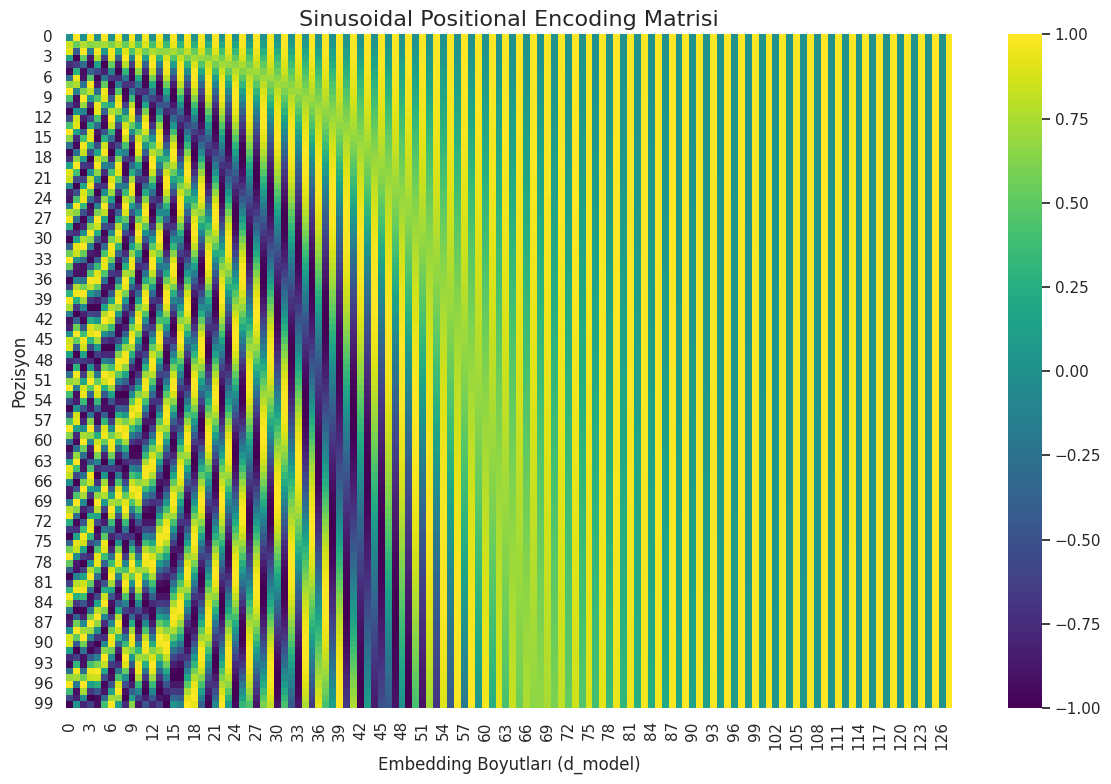

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_sinusoidal_pe(max_len, d_model):
    """
    Sinusoidal Positional Encoding matrisini oluşturan fonksiyon.
    
    Args:
        max_len (int): Maksimum dizi uzunluğu (görselleştirilecek pozisyon sayısı).
        d_model (int): Modelin embedding boyutu.

    Returns:
        torch.Tensor: (max_len, d_model) boyutunda PE matrisi.
    """
    # Boş bir PE matrisi oluştur
    pe = torch.zeros(max_len, d_model)
    
    # Pozisyonları temsil eden bir vektör oluştur (0, 1, ..., max_len-1)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    
    # Dalga frekansını belirleyen terimi hesapla
    # Bu terim, boyut indeksi arttıkça daha uzun dalga boyları (düşük frekans) üretir
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
    
    # Çift indeksli boyutlara sinüs fonksiyonunu uygula
    pe[:, 0::2] = torch.sin(position * div_term)
    
    # Tek indeksli boyutlara kosinüs fonksiyonunu uygula
    pe[:, 1::2] = torch.cos(position * div_term)
    
    return pe

# --- Görselleştirme Parametreleri ---
MAX_SEQ_LEN = 100  # Görselleştirilecek maksimum pozisyon sayısı
D_MODEL = 128      # Modelin embedding boyutu

# 1. PE matrisini oluştur
print("Sinusoidal Positional Encoding matrisi oluşturuluyor...")
pe_matrix = get_sinusoidal_pe(MAX_SEQ_LEN, D_MODEL)
print("Matris oluşturuldu.")

# 2. Matrisi bir ısı haritası (heatmap) olarak görselleştir
print("Görselleştirme oluşturuluyor...")
plt.figure(figsize=(12, 8))
sns.heatmap(pe_matrix.numpy(), cmap="viridis")

# Grafik başlığını ve eksen isimlerini ayarla
plt.title("Sinusoidal Positional Encoding Matrisi", fontsize=16)
plt.xlabel("Embedding Boyutları (d_model)", fontsize=12)
plt.ylabel("Pozisyon", fontsize=12)
plt.tight_layout()

# Görseli bir dosyaya kaydet
output_filename = "sinusoidal_pe_heatmap.png"
plt.savefig(output_filename)

print(f"\nBaşarılı! Görsel '{output_filename}' adıyla kaydedildi.")
print("Grafikteki her satır, bir pozisyon için benzersiz bir desene sahiptir.")